In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline

In [3]:
with open("../saved-experiments/width_depth_experiment_logs.pkl", "rb") as handle:
    dump = pickle.load(handle)
    
eff_dim = dump['eff_dim']
losses = dump['losses']
pars = dump['parameters']

## Construct Random Features Model

In [4]:
# random weakly informative features copied from
# https://github.com/ORIE4741/demos/blob/master/double-descent.ipynb
def build_random_features(n=100, d=100, num_informative_features = 20):
    y = np.random.randn(n)
    X = np.random.randn(n, min(d, num_informative_features)) + y.reshape(-1,1)

    if d > num_informative_features:
        X = np.hstack((X, np.random.randn(n,d - num_informative_features)))
    
    return X,y


In [5]:
def compute_eff_dim(x, s=0.1):
    return np.sum(x / (x + s))

In [6]:
def compute_partial_error(d, n=200, l=0.001):
    xtrain, ytrain = build_random_features(n=n, d = d, num_informative_features=1000)
    xtest, ytest = build_random_features(n=n, d = d, num_informative_features=1000)

    w = np.linalg.lstsq(xtrain, ytrain, rcond=None)[0]
    
    alpha = np.linalg.lstsq(xtrain @ xtrain.T +  n * l * np.eye(xtrain.shape[0]), ytrain)[0]
    train_norm = alpha.T @ xtrain @ (xtrain.T @ alpha)
    
    test_error = np.linalg.norm(xtest @ w - ytest) / np.linalg.norm(ytest)
    train_error = np.linalg.norm(xtrain @ w - ytrain) / np.linalg.norm(ytrain)
    
    svs = np.linalg.svd(xtrain, compute_uv=False)
    #eigs = np.linalg.eigvals(xtrain @ xtrain.T)
    effective_dimensions = min(n, d) - compute_eff_dim(svs**2, s=(l*n))
    
    return test_error, train_error, train_norm**0.5, effective_dimensions, svs

In [7]:
width_sequence = range(5, 400, 2)
outputs = [compute_partial_error(d) for d in width_sequence]
test_errors = [o[0] for o in outputs]
train_errors = [o[1] for o in outputs]
rf_eff_dim = [o[3] for o in outputs]

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


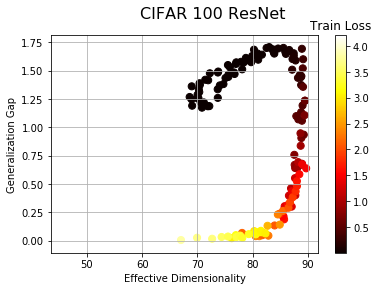

In [14]:
import seaborn as sns

eff_dim2 = eff_dim.reshape(-1)
train_loss2 = losses[0].reshape(-1)
test_loss2 = losses[2].reshape(-1)

gen_gap = test_loss2 - train_loss2

cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(eff_dim2, gen_gap, c=train_loss2, s=50, cmap="hot")
g = f.colorbar(points)
g.ax.set_title('Train Loss')

f.suptitle("CIFAR 100 ResNet", fontsize=16)
ax.set_xlabel('Effective Dimensionality')
ax.set_ylabel('Generalization Gap')
ax.grid()

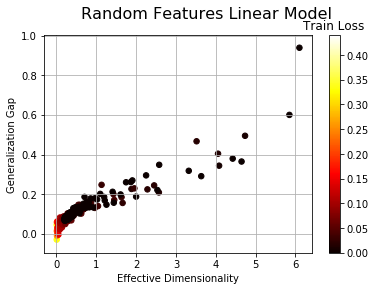

In [13]:
from matplotlib.lines import Line2D

cmap = sns.cubehelix_palette(as_cmap=True)
rf_gen_gap = [test - train for test, train in zip(test_errors, train_errors)]
f, ax = plt.subplots()
points = ax.scatter(rf_eff_dim, rf_gen_gap, c=train_errors, s=30, cmap="hot")
g = f.colorbar(points)
g.ax.set_title('Train Loss')

f.suptitle("Random Features Linear Model", fontsize=16)
ax.set_xlabel('Effective Dimensionality')
ax.set_ylabel('Generalization Gap')
ax.grid()

(-0.1, 1.0)

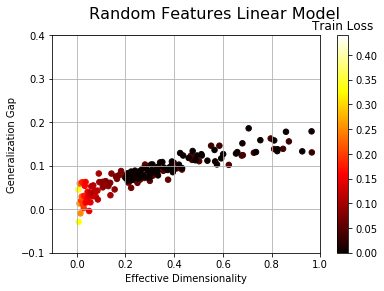

In [12]:
f, ax = plt.subplots()
points = ax.scatter(rf_eff_dim, rf_gen_gap, c=train_errors, s=30, cmap="hot")
g = f.colorbar(points)
g.ax.set_title('Train Loss')

f.suptitle("Random Features Linear Model", fontsize=16)
ax.set_xlabel('Effective Dimensionality')
ax.set_ylabel('Generalization Gap')
ax.grid()

ax.set_ylim(-0.1, 0.4)
ax.set_xlim(-0.1, 1.)